# Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dataframe dos resultados

In [2]:
path = "/home/lucas/experimentos/Novo_modelo/version_2/metrics.csv"

df = pd.read_csv(path)
df

,loss,epoch,step,val_loss
0,0.036842,0,49,NaN
1,0.042772,0,99,NaN
2,0.080917,0,149,NaN
3,0.057924,0,199,NaN
4,0.048316,0,249,NaN
...,...,...,...,...
269,0.041556,12,12899,NaN
270,0.033505,12,12949,NaN
271,0.041178,12,12999,NaN
272,0.039155,12,13049,NaN


# 2. Obtendo a loss de treino e de validacao

## 2.1 Validacao

In [3]:
#df_val_loss = df[df['val_loss'].apply(lambda x: pd.notna(x))].copy()
df_val_loss = df[["epoch","val_loss"]].copy()
df_val_loss.rename({"val_loss":"loss"},inplace=True,axis=1)
df_val_loss["Split"] = "Validação"

df_val_loss = df_val_loss[df_val_loss.loss.apply(lambda x: pd.notna(x))]
df_val_loss

,epoch,loss,Split
20,0,0.059592,Validação
41,1,0.059769,Validação
62,2,0.059669,Validação
83,3,0.059603,Validação
104,4,0.059555,Validação
125,5,0.059658,Validação
146,6,0.059797,Validação
167,7,0.059552,Validação
188,8,0.059597,Validação
209,9,0.059563,Validação


## 2.2 Treino

In [4]:
#index_val = df_val_loss.index.tolist()

#index_val = [x - 1 for x in index_val]
#df_train_loss = df.loc[index_val].copy()
df_train_loss = df[["epoch","loss"]].copy()

df_train_loss["Split"] = "Treino"
df_train_loss

,epoch,loss,Split
0,0,0.036842,Treino
1,0,0.042772,Treino
2,0,0.080917,Treino
3,0,0.057924,Treino
4,0,0.048316,Treino
...,...,...,...
269,12,0.041556,Treino
270,12,0.033505,Treino
271,12,0.041178,Treino
272,12,0.039155,Treino


# 3. Grafico comparativo de Loss

In [5]:
df_concat = pd.concat([df_train_loss,df_val_loss])

<Axes: xlabel='epoch', ylabel='loss'>

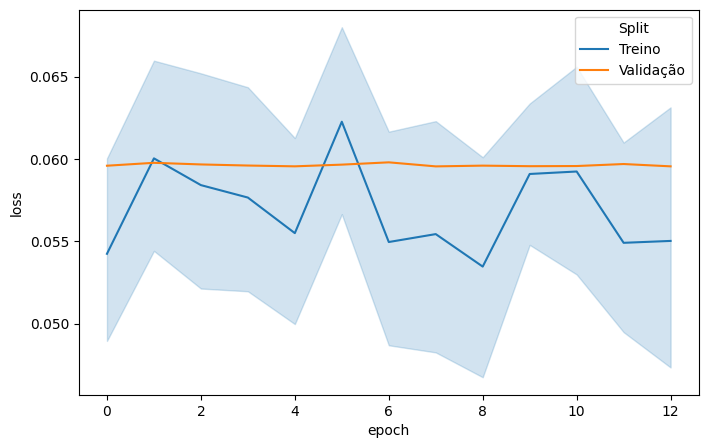

In [6]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=df_concat,x="epoch",y="loss",hue="Split",ax=ax)

#sns.lineplot(data=df,x="epoch",y="loss",ax=ax)
#sns.lineplot(data=df,x="epoch",y="val_loss",ax=ax)

# 4. Load Model

In [7]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
sys.path.append("/home/lucas/Image-Denoising/src")


import pandas as pd
from PIL import Image
from tqdm import tqdm

from model_v2 import VisionModel
from noises import add_noise
from dataset import CustomImageDataset

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from utils.light_module import LightningVisionTransformer
from torchvision.transforms import v2

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch import Trainer

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
class AddNoise(torch.nn.Module):
    def forward(self, img, noise,**kwargs):
        noisy_image = add_noise(img, noise_type=noise,**kwargs)

        return Image.fromarray(noisy_image)

batch_size = 2
num_workers = 8
lr = 0.001

noise = AddNoise()
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

path = "/home/lucas/Image-Denoising/dataframes/dataframe_v1.csv"
df = pd.read_csv(path)

val = df[df["split"] == 'val']

val_dataset = CustomImageDataset(val,transform,noise)


custom_dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)



model = VisionModel(
    img_size=(batch_size,3,224,224),
    patch_size=14,
    #patch_size=28,
    #token_len=512,
    token_len=512,
    embed_dim=512,
    num_layers=12,
    num_heads=16
)

model = model.cpu()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

model = LightningVisionTransformer.load_from_checkpoint(
    "/home/lucas/experimentos/Novo_modelo/version_2/checkpoint-epoch=07-val_loss=0.06.ckpt",
    map_location={"cuda:0":"cpu","cuda:1":"cpu","cuda":"cpu"},
    model=model,
    loss=loss_fn,
    optim=optimizer
)

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# 5 Testando inferencias

In [9]:
i = 0
stop = 2
for ori_img, noi_img in custom_dataloader_val:
    if(i == stop):
        break
    i+=1

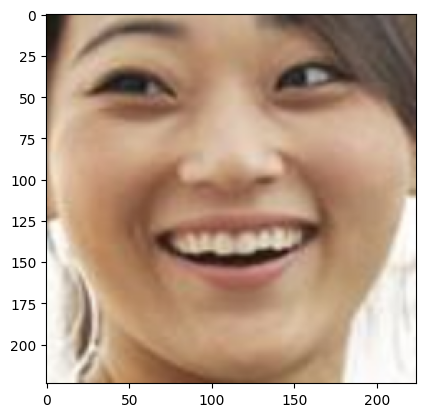

In [10]:
plt.imshow(ori_img[0].permute(1,2,0).detach().numpy())

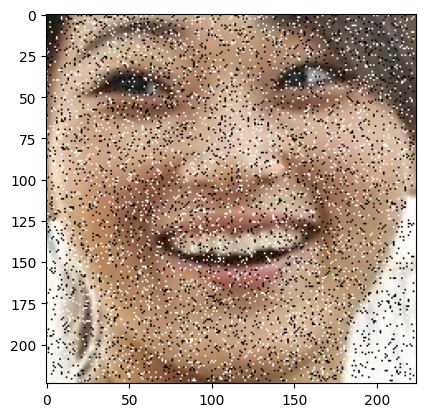

In [11]:
plt.imshow(noi_img[0].permute(1,2,0).detach().numpy())

In [12]:
denoised = model.model(noi_img)

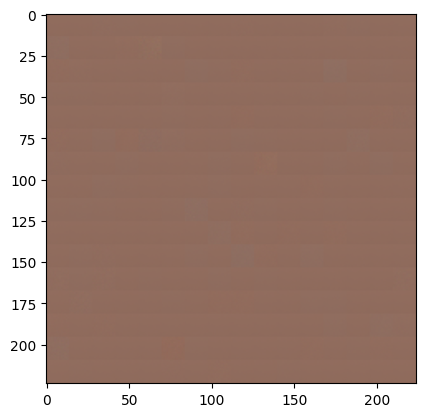

In [14]:
plt.imshow(denoised[1].permute(1,2,0).detach().numpy())

In [16]:
denoised[0]

tensor([[[0.5698, 0.5700, 0.5700,  ..., 0.5748, 0.5703, 0.5693],
         [0.5679, 0.5690, 0.5693,  ..., 0.5742, 0.5724, 0.5713],
         [0.5690, 0.5684, 0.5686,  ..., 0.5770, 0.5687, 0.5734],
         ...,
         [0.5597, 0.5580, 0.5602,  ..., 0.5621, 0.5622, 0.5622],
         [0.5593, 0.5587, 0.5595,  ..., 0.5611, 0.5603, 0.5610],
         [0.5578, 0.5570, 0.5583,  ..., 0.5597, 0.5608, 0.5603]],

        [[0.4286, 0.4274, 0.4262,  ..., 0.4238, 0.4225, 0.4220],
         [0.4269, 0.4271, 0.4265,  ..., 0.4237, 0.4247, 0.4256],
         [0.4249, 0.4257, 0.4257,  ..., 0.4249, 0.4228, 0.4275],
         ...,
         [0.4234, 0.4203, 0.4218,  ..., 0.4202, 0.4204, 0.4186],
         [0.4205, 0.4224, 0.4225,  ..., 0.4199, 0.4188, 0.4187],
         [0.4210, 0.4199, 0.4214,  ..., 0.4196, 0.4192, 0.4181]],

        [[0.3702, 0.3700, 0.3693,  ..., 0.3717, 0.3664, 0.3673],
         [0.3688, 0.3696, 0.3703,  ..., 0.3689, 0.3713, 0.3692],
         [0.3685, 0.3680, 0.3687,  ..., 0.3709, 0.3674, 0.

In [15]:
denoised[1]

tensor([[[0.5696, 0.5695, 0.5699,  ..., 0.5710, 0.5693, 0.5716],
         [0.5675, 0.5681, 0.5695,  ..., 0.5695, 0.5693, 0.5695],
         [0.5695, 0.5682, 0.5688,  ..., 0.5678, 0.5690, 0.5691],
         ...,
         [0.5600, 0.5621, 0.5618,  ..., 0.5614, 0.5603, 0.5615],
         [0.5596, 0.5603, 0.5596,  ..., 0.5614, 0.5593, 0.5602],
         [0.5604, 0.5594, 0.5598,  ..., 0.5591, 0.5605, 0.5592]],

        [[0.4279, 0.4281, 0.4261,  ..., 0.4289, 0.4276, 0.4265],
         [0.4267, 0.4266, 0.4264,  ..., 0.4268, 0.4273, 0.4270],
         [0.4250, 0.4257, 0.4261,  ..., 0.4258, 0.4255, 0.4265],
         ...,
         [0.4202, 0.4204, 0.4221,  ..., 0.4197, 0.4198, 0.4193],
         [0.4203, 0.4208, 0.4201,  ..., 0.4209, 0.4189, 0.4182],
         [0.4209, 0.4198, 0.4189,  ..., 0.4182, 0.4177, 0.4183]],

        [[0.3706, 0.3699, 0.3705,  ..., 0.3700, 0.3693, 0.3686],
         [0.3695, 0.3700, 0.3702,  ..., 0.3699, 0.3698, 0.3697],
         [0.3680, 0.3685, 0.3692,  ..., 0.3690, 0.3693, 0.